Assorted plots
==============

_15 to 22 July 2021_ <br />
_Chuan-Zheng Lee <czlee@stanford.edu>_ <br />
_Rough working_

This contains lots of plots from runs over the last few days.

It's kind of like the sequel to `ota-basic.py`.

In [1]:
from pathlib import Path

from plots_utils import plot_averaged_training_charts, plot_evaluation_vs_clients, show_timestamp_info

# Averaged out over many iterations

I ran the $B = 1, \sigma_\mathrm{n}^2 = 0.1$ with 13,333 data samples per client case repeatedly to try to smooth out the graphs above, to get a better idea of expected performance.

These were all done on commit `bef163a`. This after I implemented the class-based framework, so it is probably subject to the bug I noticed in [1b5e659](https://github.com/czlee/jadeite/commit/1b5e659b8342f1eeb38c909418512c0568095c01). However, it won't be extremely noticeable, because all fo the following experiments were done using the same parameters, changing only `clients` (which isn't subject to the bug). Also, the `data_per_client` option isn't subject to the bug, because it's not passed to `Experiment` class constructors in `params`. So basically the only change from defaults was `noise = 0.1`, and there's a good chance the following is actually with `noise = 1.0`, not 0.1 as claimed.

In [2]:
results_dir = Path("../results-downloaded/ota-basic-4/")
show_timestamp_info(results_dir)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **14 Jul 2021, 04:13:16** | 14 Jul 2021, 04:14:03 | 47 s |
| last to finish | 14 Jul 2021, 18:06:20 | **14 Jul 2021, 18:09:36** | 3 min 16 s |
| shortest | 14 Jul 2021, 04:13:16 | 14 Jul 2021, 04:14:03 | **47 s** |
| longest | 14 Jul 2021, 13:55:59 | 14 Jul 2021, 14:06:35 | **10 min 35 s** |


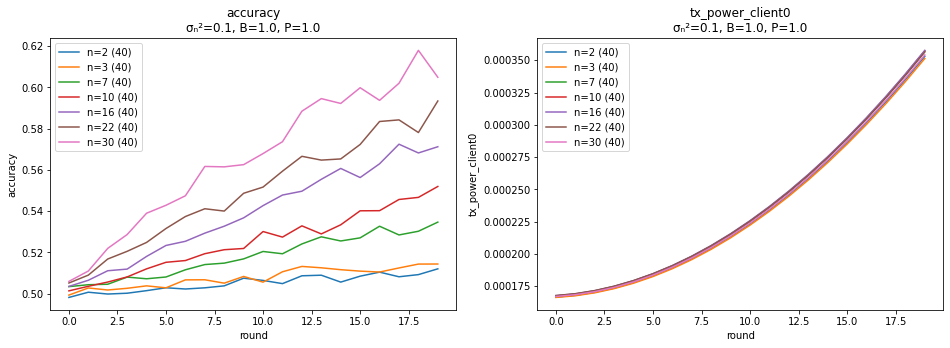

In [3]:
title_specs = {
    'noise': 0.1,
    'parameter_radius': 1.0,
    'power': 1.0,
}
fixed_specs = {
    'rounds': 20,
    'batch_size': 64,
    'lr_client': 0.01,
    'momentum_client': 0.0,
    'epochs': 1,
    'dataset': 'epsilon',
    'data_per_client': 13333,
}
series_specs = {
    'clients': [2, 3, 7, 10, 16, 22, 30],
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


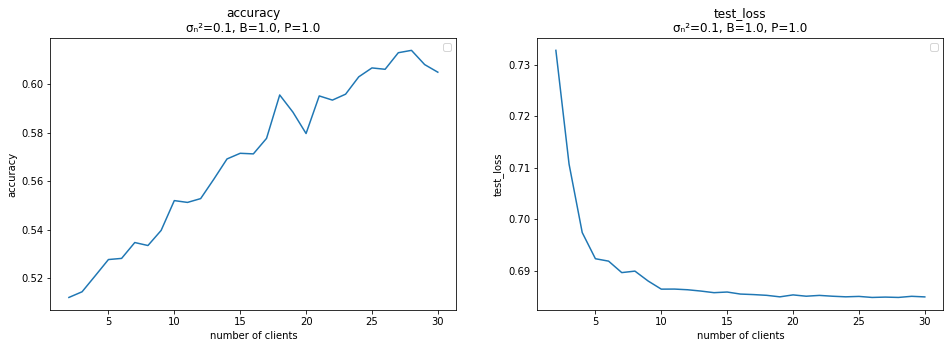

In [4]:
series_specs = {}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Really long experiments on the class-based framework—probably mislabelled

I think these are subject to the bug fixed in commit [`1b5e569`](https://github.com/czlee/jadeite/commit/1b5e659b8342f1eeb38c909418512c0568095c01). See the relevant section below for details. Basically, parameters passed via `params` were probably being ignored. A lot of command-line options weren't necessarily subject to this bug, but some crucial ones were, like `noise`, `power` and `parameter_radius`.

In [5]:
results_dir = Path("../results-downloaded/20210715-20210717-bef163a/")
show_timestamp_info(results_dir)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **15 Jul 2021, 02:17:15** | 15 Jul 2021, 02:18:27 | 1 min 11 s |
| last to finish | 18 Jul 2021, 23:26:10 | **18 Jul 2021, 23:27:15** | 1 min 05 s |
| shortest | 18 Jul 2021, 20:55:54 | 18 Jul 2021, 20:56:36 | **41 s** |
| longest | 15 Jul 2021, 20:58:59 | 15 Jul 2021, 22:00:50 | **1 h 01 min 51 s** |


/home/czlee/jadeite/jupyter/plots_utils.py:280: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[series][field][directory] = training[field]


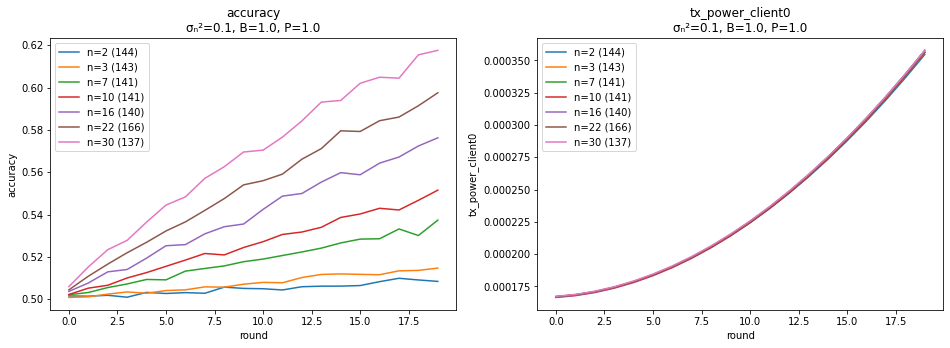

In [6]:
title_specs = {
    'noise': 0.1,
    'parameter_radius': 1.0,
    'power': 1.0,
}
series_specs = {
    'clients': [2, 3, 7, 10, 16, 22, 30],
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


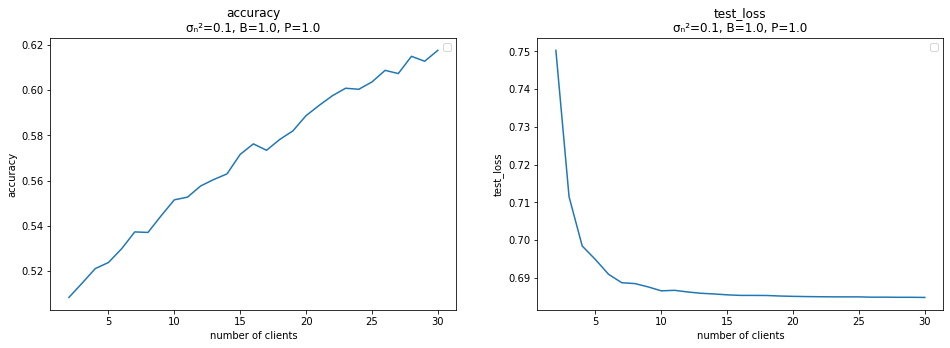

In [7]:
series_specs = {}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Deltas vs params, on commit `9bdb857`—not reliable, discard

These runs didn't run to completion, as in, I stopped them early. This is because I discovered a major bug in parameter handling. See the next section for details, but basically, most command-line arguments were being ignored by the framework.

So I would expect these plots to be identical regardless of what parameters are used, because it's not actually recognizing the parameters!

In [8]:
results_dir = Path("../results-downloaded/20210719-9bdb857/")
show_timestamp_info(results_dir)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **19 Jul 2021, 21:35:07** | 19 Jul 2021, 21:35:54 | 47 s |
| last to finish | 20 Jul 2021, 00:23:10 | **20 Jul 2021, 00:25:55** | 2 min 45 s |
| shortest | 19 Jul 2021, 21:35:21 | 19 Jul 2021, 21:36:05 | **44 s** |
| longest | 19 Jul 2021, 23:51:34 | 19 Jul 2021, 23:55:52 | **4 min 17 s** |


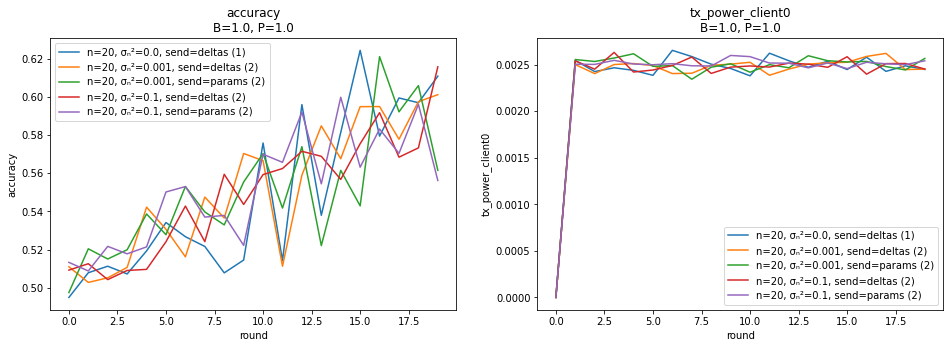

In [9]:
title_specs = {
    'parameter_radius': 1.0,
    'power': 1.0,
}
series_specs = {
    'clients': [20],
    'noise': [0.0, 0.001, 0.1],
    'send': '__all__',
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

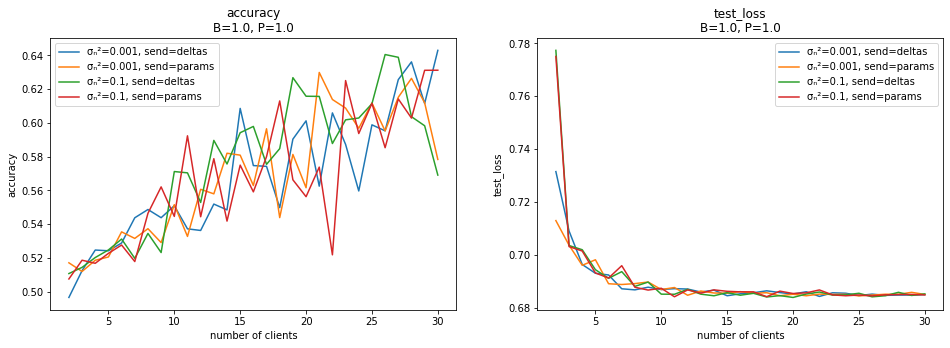

In [10]:
series_specs = {
    'noise': [0.001, 0.1],
    'send': '__all__',
}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Deltas vs params, on commit `1b5e659`

Okay, here's the fix. You can see this fix here:
> https://github.com/czlee/jadeite/commit/1b5e659b8342f1eeb38c909418512c0568095c01

Or the comparison between this commit and the ones in the following section:
> https://github.com/czlee/jadeite/compare/9bdb857...1b5e659

In [11]:
results_dir = Path("../results-downloaded/20210720-1b5e659/")
show_timestamp_info(results_dir)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **20 Jul 2021, 00:36:10** | 20 Jul 2021, 00:37:01 | 51 s |
| last to finish | 20 Jul 2021, 13:23:02 | **20 Jul 2021, 13:26:52** | 3 min 49 s |
| shortest | 20 Jul 2021, 07:50:43 | 20 Jul 2021, 07:51:31 | **47 s** |
| longest | 20 Jul 2021, 08:14:46 | 20 Jul 2021, 08:19:16 | **4 min 30 s** |


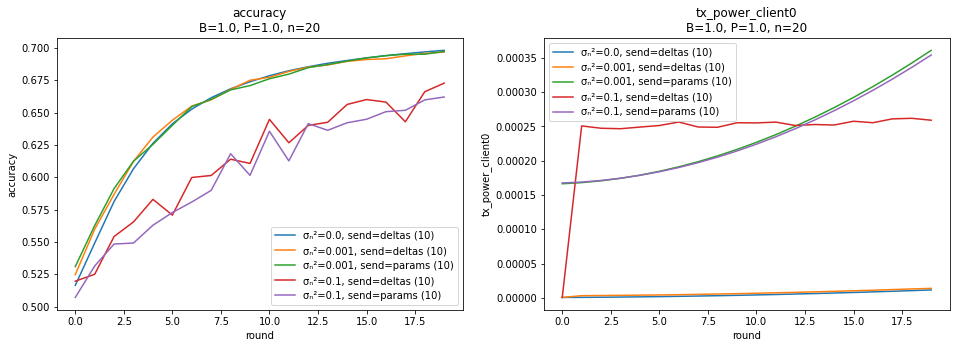

In [12]:
title_specs = {
    'parameter_radius': 1.0,
    'power': 1.0,
    'clients': 20,
}
series_specs = {
    'noise': [0.0, 0.001, 0.1],
    'send': '__all__',
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

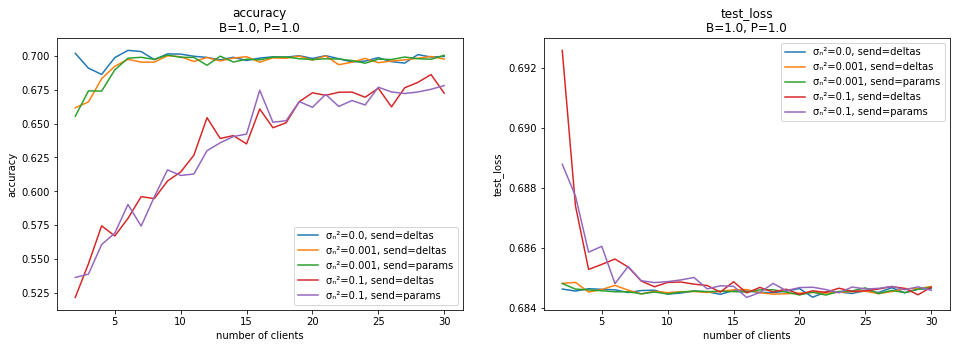

In [13]:
del title_specs['clients']
series_specs = {
    'noise': '__all__',
    'send': '__all__',
}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Digital simulations 1

In [14]:
results_dir = Path("../results-downloaded/20210720-stocquant/")
show_timestamp_info(results_dir)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **20 Jul 2021, 17:29:58** | 20 Jul 2021, 17:30:46 | 48 s |
| last to finish | 21 Jul 2021, 00:43:00 | **21 Jul 2021, 00:46:44** | 3 min 43 s |
| shortest | 20 Jul 2021, 23:41:31 | 20 Jul 2021, 23:42:14 | **43 s** |
| longest | 20 Jul 2021, 17:40:40 | 20 Jul 2021, 20:05:39 | **2 h 24 min 58 s** |


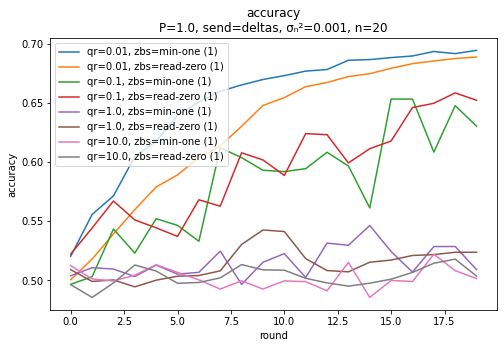

In [15]:
fixed_specs = {
    'rounds': 20,
    'batch_size': 64,
    'lr_client': 0.01,
    'momentum_client': 0.0,
    'epochs': 1,
    'dataset': 'epsilon',
    'data_per_client': 13333,
    'channel_uses': None,
    'send': 'deltas',
}
title_specs = {
    'power': 1.0,
    'send': 'deltas',
    'noise': 0.001,
    'clients': 20,
}
series_specs = {
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

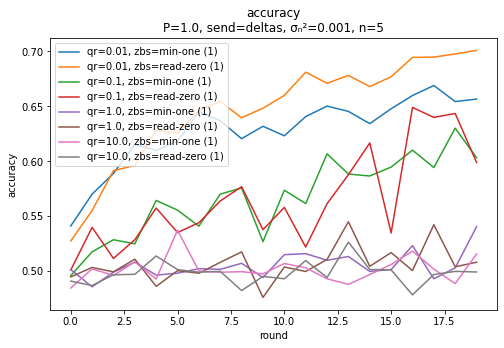

In [16]:
title_specs['clients'] = 5
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

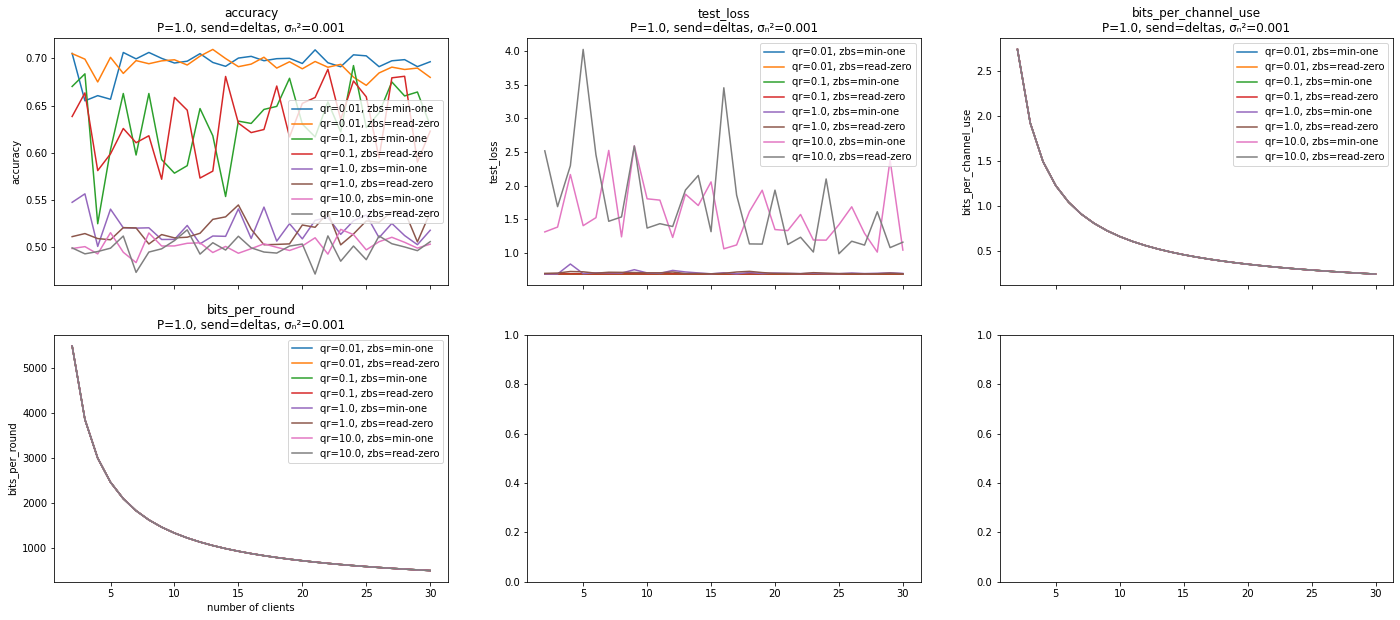

In [17]:
del title_specs['clients']
series_specs = {
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy', 'test_loss', 'bits_per_channel_use', 'bits_per_round']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Digital simulations 2

Tried a few different values to see what changes.

In [18]:
results_dir = Path("../results-downloaded/20210721-stocquant/")
show_timestamp_info(results_dir)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **21 Jul 2021, 06:21:38** | 21 Jul 2021, 06:22:26 | 48 s |
| last to finish | 21 Jul 2021, 10:45:49 | **21 Jul 2021, 10:49:35** | 3 min 45 s |
| shortest | 21 Jul 2021, 06:21:38 | 21 Jul 2021, 06:22:26 | **48 s** |
| longest | 21 Jul 2021, 07:44:00 | 21 Jul 2021, 07:49:00 | **5 min 00 s** |


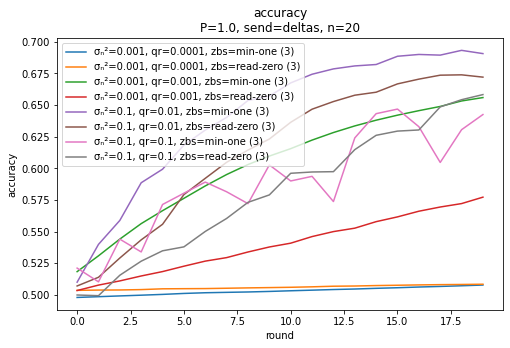

In [19]:
title_specs = {
    'power': 1.0,
    'send': 'deltas',
    'clients': 20,
}
series_specs = {
    'noise': '__all__',
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

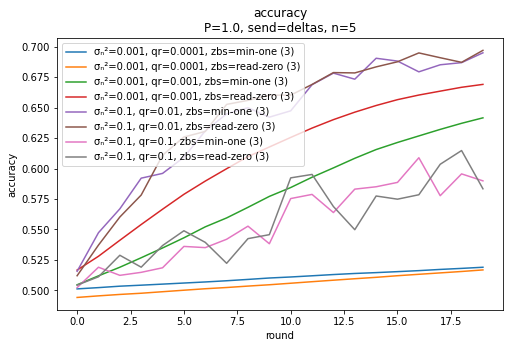

In [20]:
title_specs['clients'] = 5
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

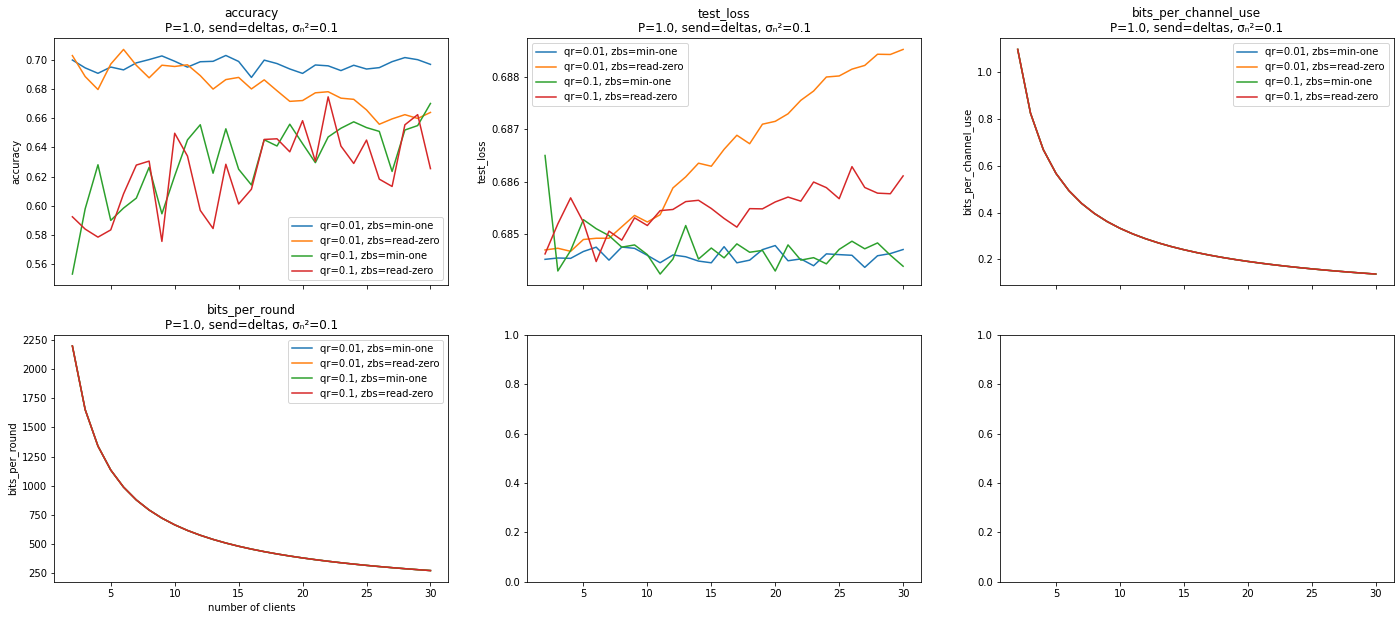

In [21]:
del title_specs['clients']
title_specs['noise'] = 0.1
series_specs = {
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy', 'test_loss', 'bits_per_channel_use', 'bits_per_round']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

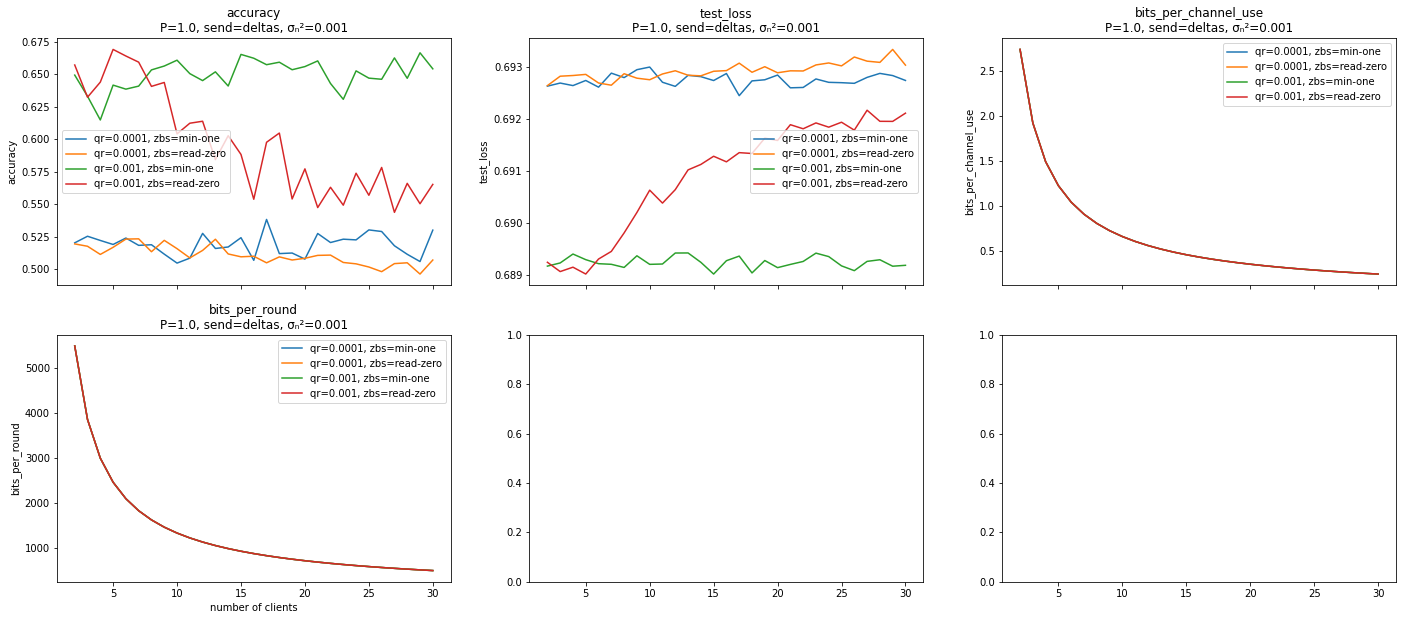

In [22]:
title_specs['noise'] = 0.001
series_specs = {
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Digital simulations 1 and 2

In [23]:
results_dir = [Path("../results-downloaded/20210720-stocquant/"), Path("../results-downloaded/20210721-stocquant/")]
show_timestamp_info(results_dir)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **20 Jul 2021, 17:29:58** | 20 Jul 2021, 17:30:46 | 48 s |
| last to finish | 21 Jul 2021, 10:45:49 | **21 Jul 2021, 10:49:35** | 3 min 45 s |
| shortest | 20 Jul 2021, 23:41:31 | 20 Jul 2021, 23:42:14 | **43 s** |
| longest | 20 Jul 2021, 17:40:40 | 20 Jul 2021, 20:05:39 | **2 h 24 min 58 s** |


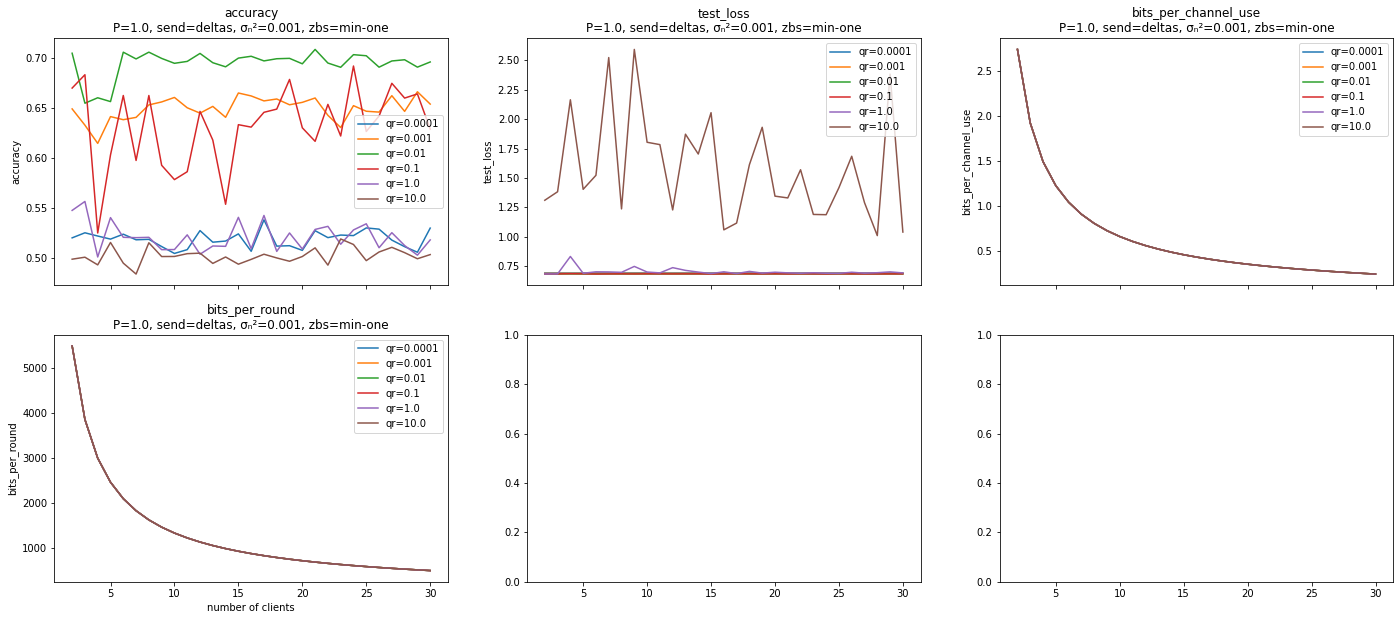

In [24]:
title_specs['noise'] = 0.001
title_specs['zero_bits_strategy'] = 'min-one'
series_specs = {
    'quantization_range': '__all__',
}

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

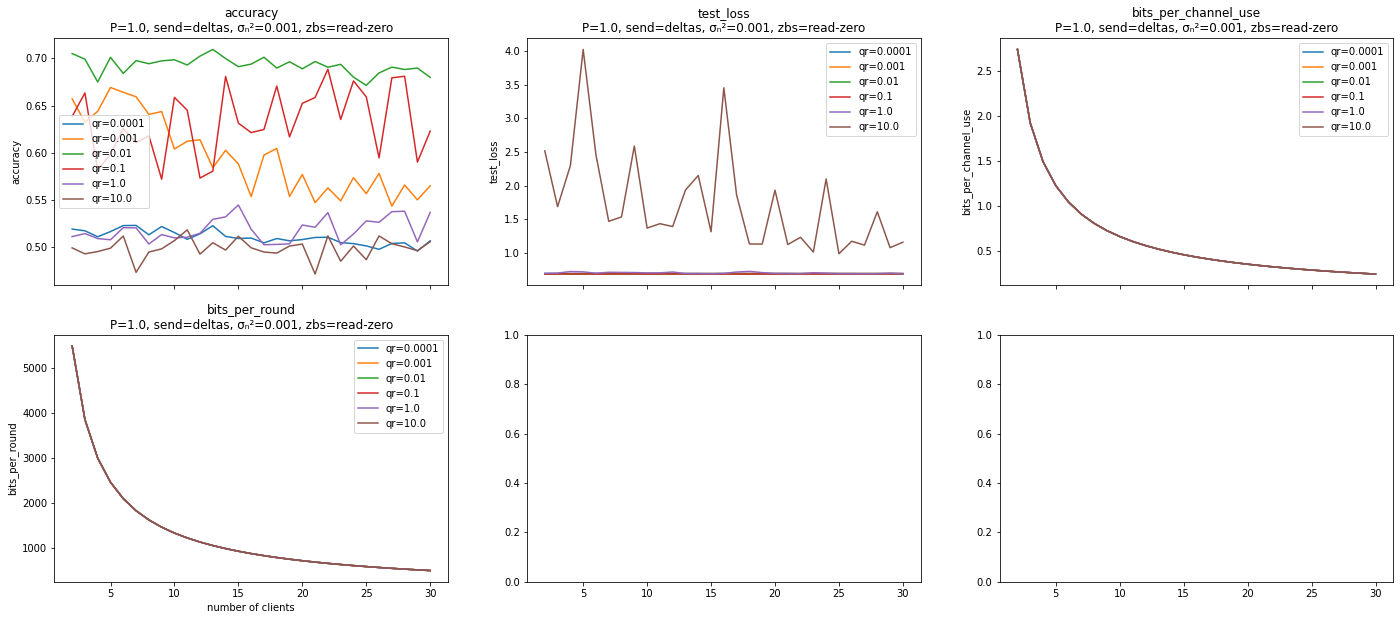

In [25]:
title_specs['zero_bits_strategy'] = 'read-zero'

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

Current thinking [22 July]:

- The digital regime is in effect still using a lot more power than the analog scheme, because we are using all of the power in the digital scheme (via the channel capacity), whereas in the analog scheme, we're not intelligently scaling for power, and we can see in the `tx_power_client0` plots that the amount of power actually used is often under 0.001, which is like 1000 times less power than the 1.0 we intended to be using. We could scale digital power down, but we're using only a handful of bits as it is.
- The digital scheme seems passable. Next step is to make sure that power comparison is really fair.
- We'll probably want to do some sort of dynamic power scaling to get that to work. To get things going, say it's fine to assume there's a side-channel that clients can use to communicate what they think $B$ should be.


Which plot?
- The "number of clients" plot isn't as insightful as first appears in this case. At the moment, we're just taking the accuracy after 20 rounds. This cutoff is kind of arbitrarily chosen, and it's quite near the beginning of training.
- Training until convergence doesn't make sense—all of them will (or should) converge to the same place, they'll just take different amounts of time to do so. So we would expect "accuracy at convergence" plots to be flat.
- The better thing to do is probably just to do training plots (accuracy vs round number) for a _fixed_ number of clients, and let that tell the story. It doesn't give as much insight about scaling in $n$, but at least it's harder to suggest that we're cherry-picking the point of measurement.